In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

In [2]:
IMAGE_DIR = Path('./butterflies/train')
DESC_CSV = Path('./butterflies/Training_set.csv')

## Load dataset

In [3]:
desc_df = pd.read_csv(DESC_CSV)
len(desc_df)

6499

In [4]:
desc_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

## Plot data

In [5]:
def plot_distribution(class_counts):
    plt.figure(figsize=(10, 8))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribution of Butterfly Classes')
    plt.xlabel('Butterfly Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

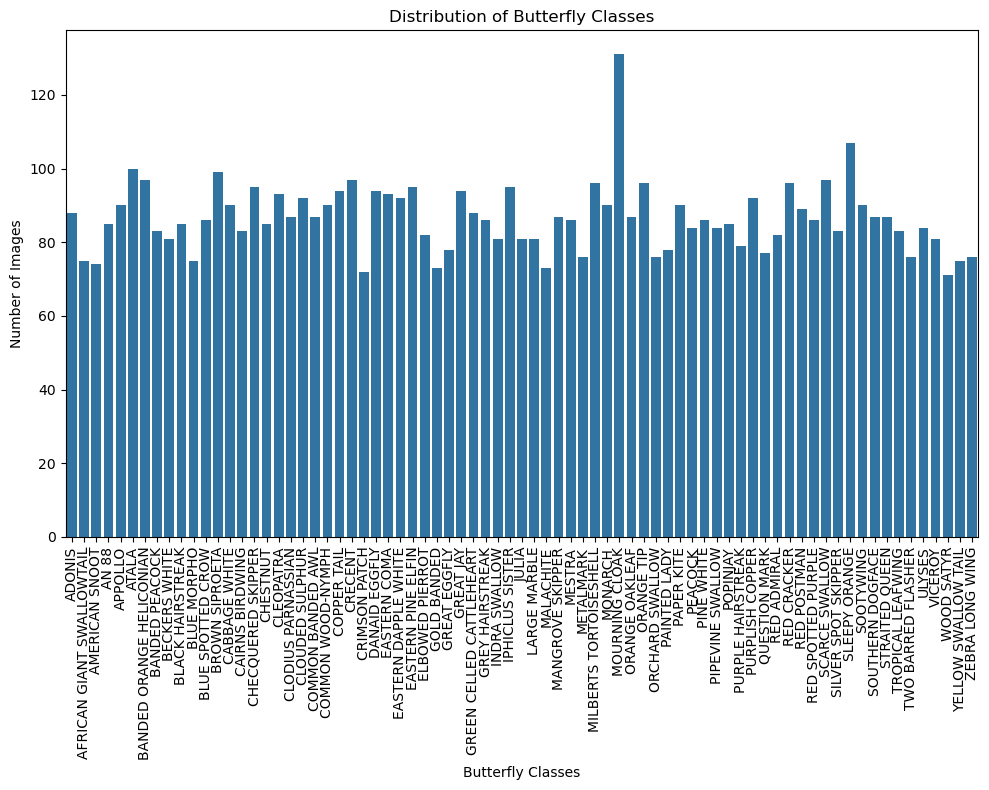

In [6]:
class_counts = desc_df['label'].value_counts().sort_index()
plot_distribution(class_counts)

## Only take a subset of the classes

In [202]:
keep_class_number = 65

top_classes = class_counts.sort_values(ascending=False).head(keep_class_number).index

df_filtered = desc_df[desc_df['label'].isin(top_classes)]
df_unknown =  desc_df[~desc_df['label'].isin(top_classes)]

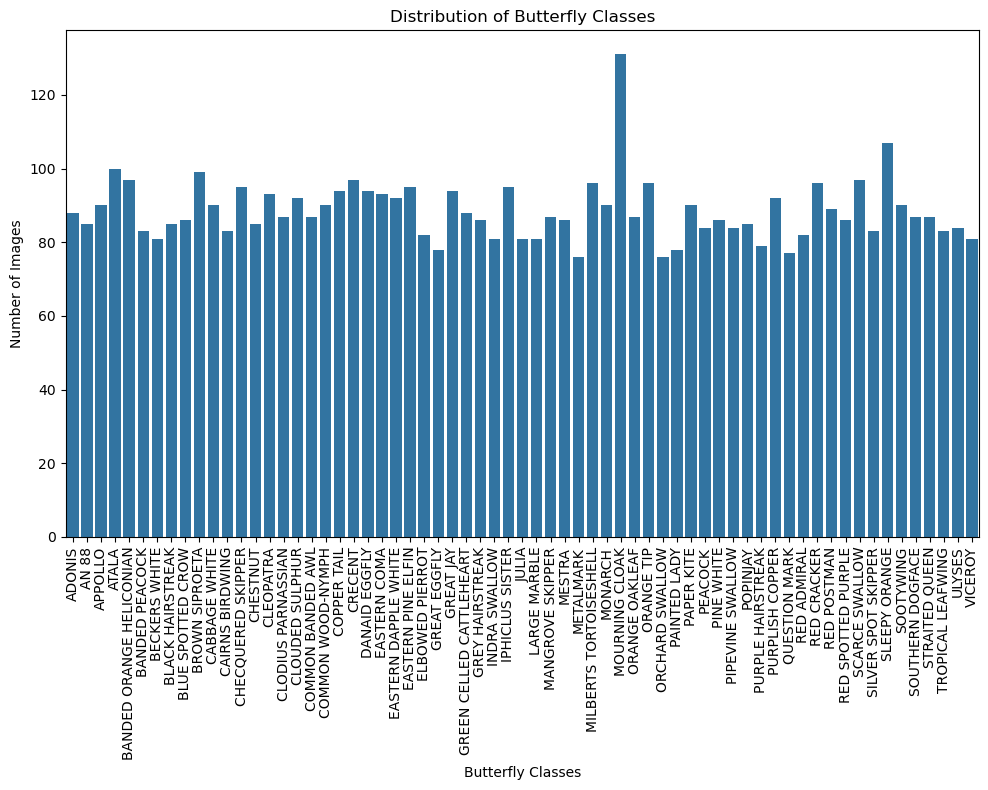

In [203]:
class_counts_f = df_filtered['label'].value_counts().sort_index()
plot_distribution(class_counts_f)

## Undersample to balance the distribution

In [204]:
min_count = df_filtered['label'].value_counts().min()

df_balanced = df_filtered.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))

df_balanced = df_balanced.reset_index(drop=True)

print(df_balanced['label'].value_counts())

label
ADONIS                      76
LARGE MARBLE                76
MESTRA                      76
METALMARK                   76
MILBERTS TORTOISESHELL      76
                            ..
GREAT JAY                   76
GREEN CELLED CATTLEHEART    76
GREY HAIRSTREAK             76
INDRA SWALLOW               76
VICEROY                     76
Name: count, Length: 65, dtype: int64


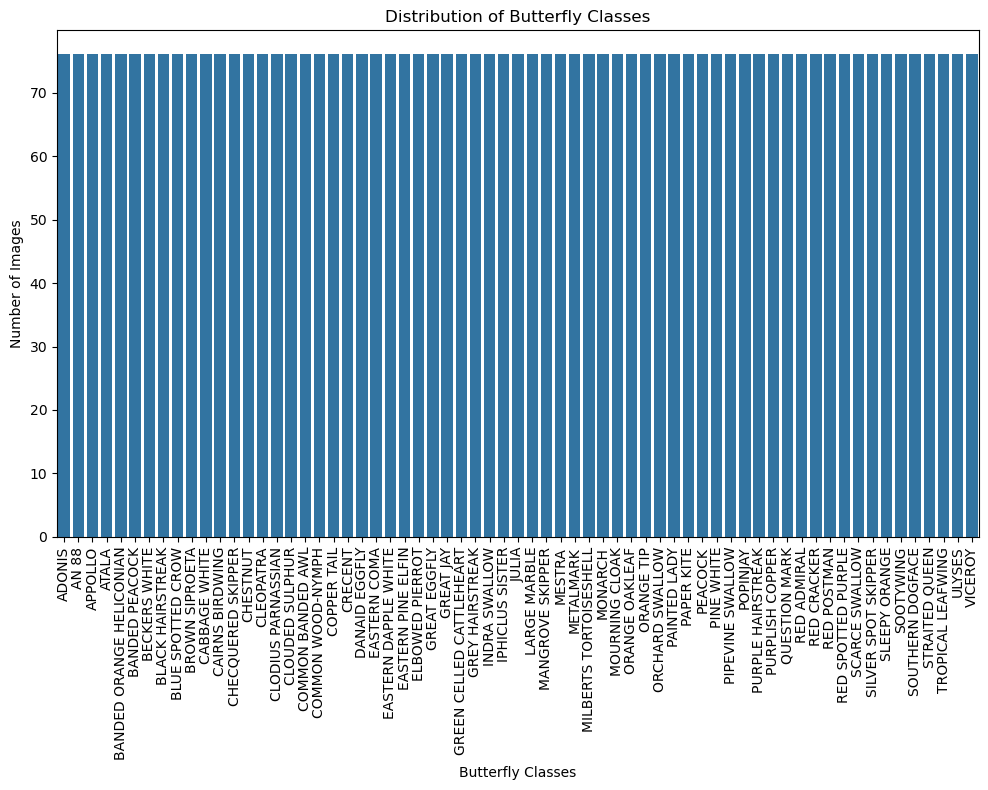

In [205]:
class_counts_b = df_balanced['label'].value_counts().sort_index()
plot_distribution(class_counts_b)

## Show examples

### Trained classes example

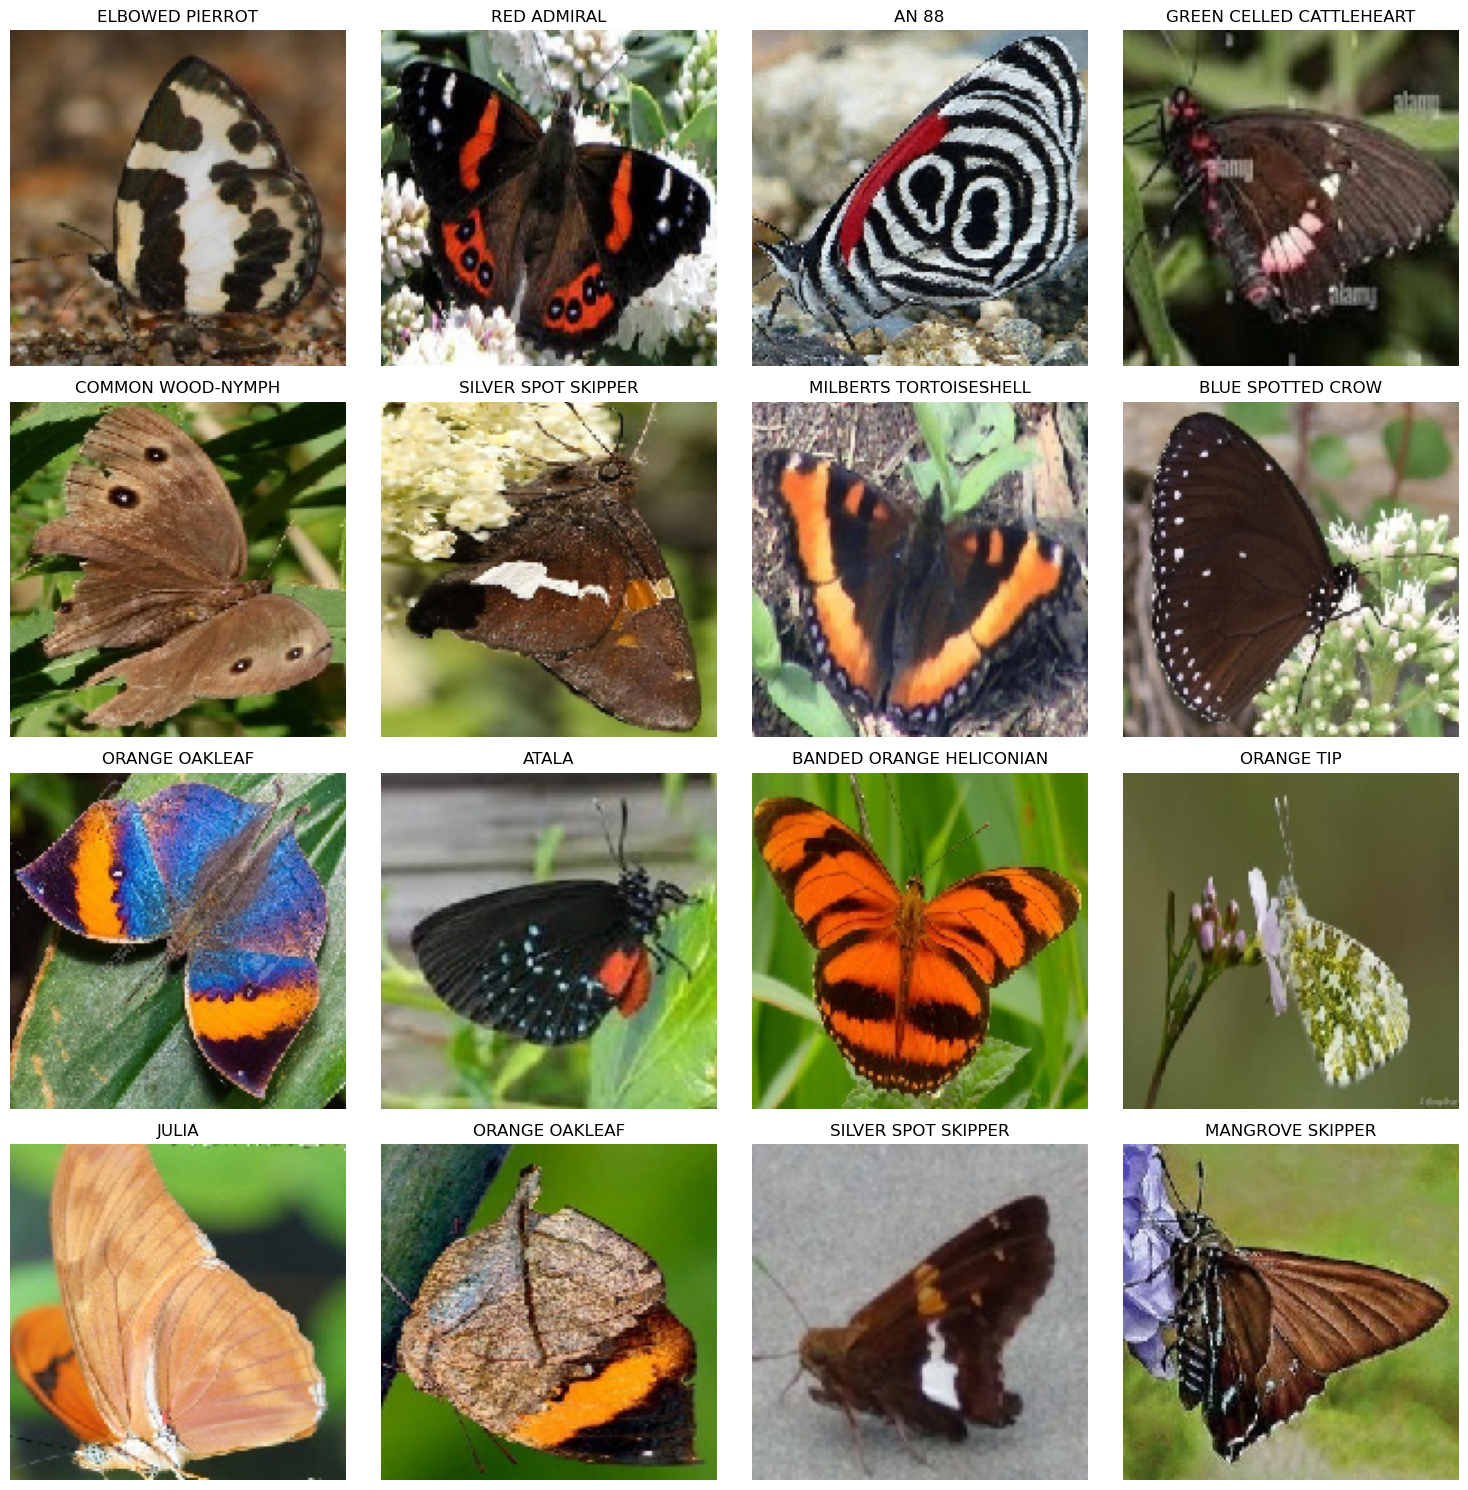

In [206]:
sample_images = df_balanced.sample(16, random_state=42)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = IMAGE_DIR / row['filename']
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 4, i % 4]
    ax.imshow(img_array)
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()


### Examples of unknown classes

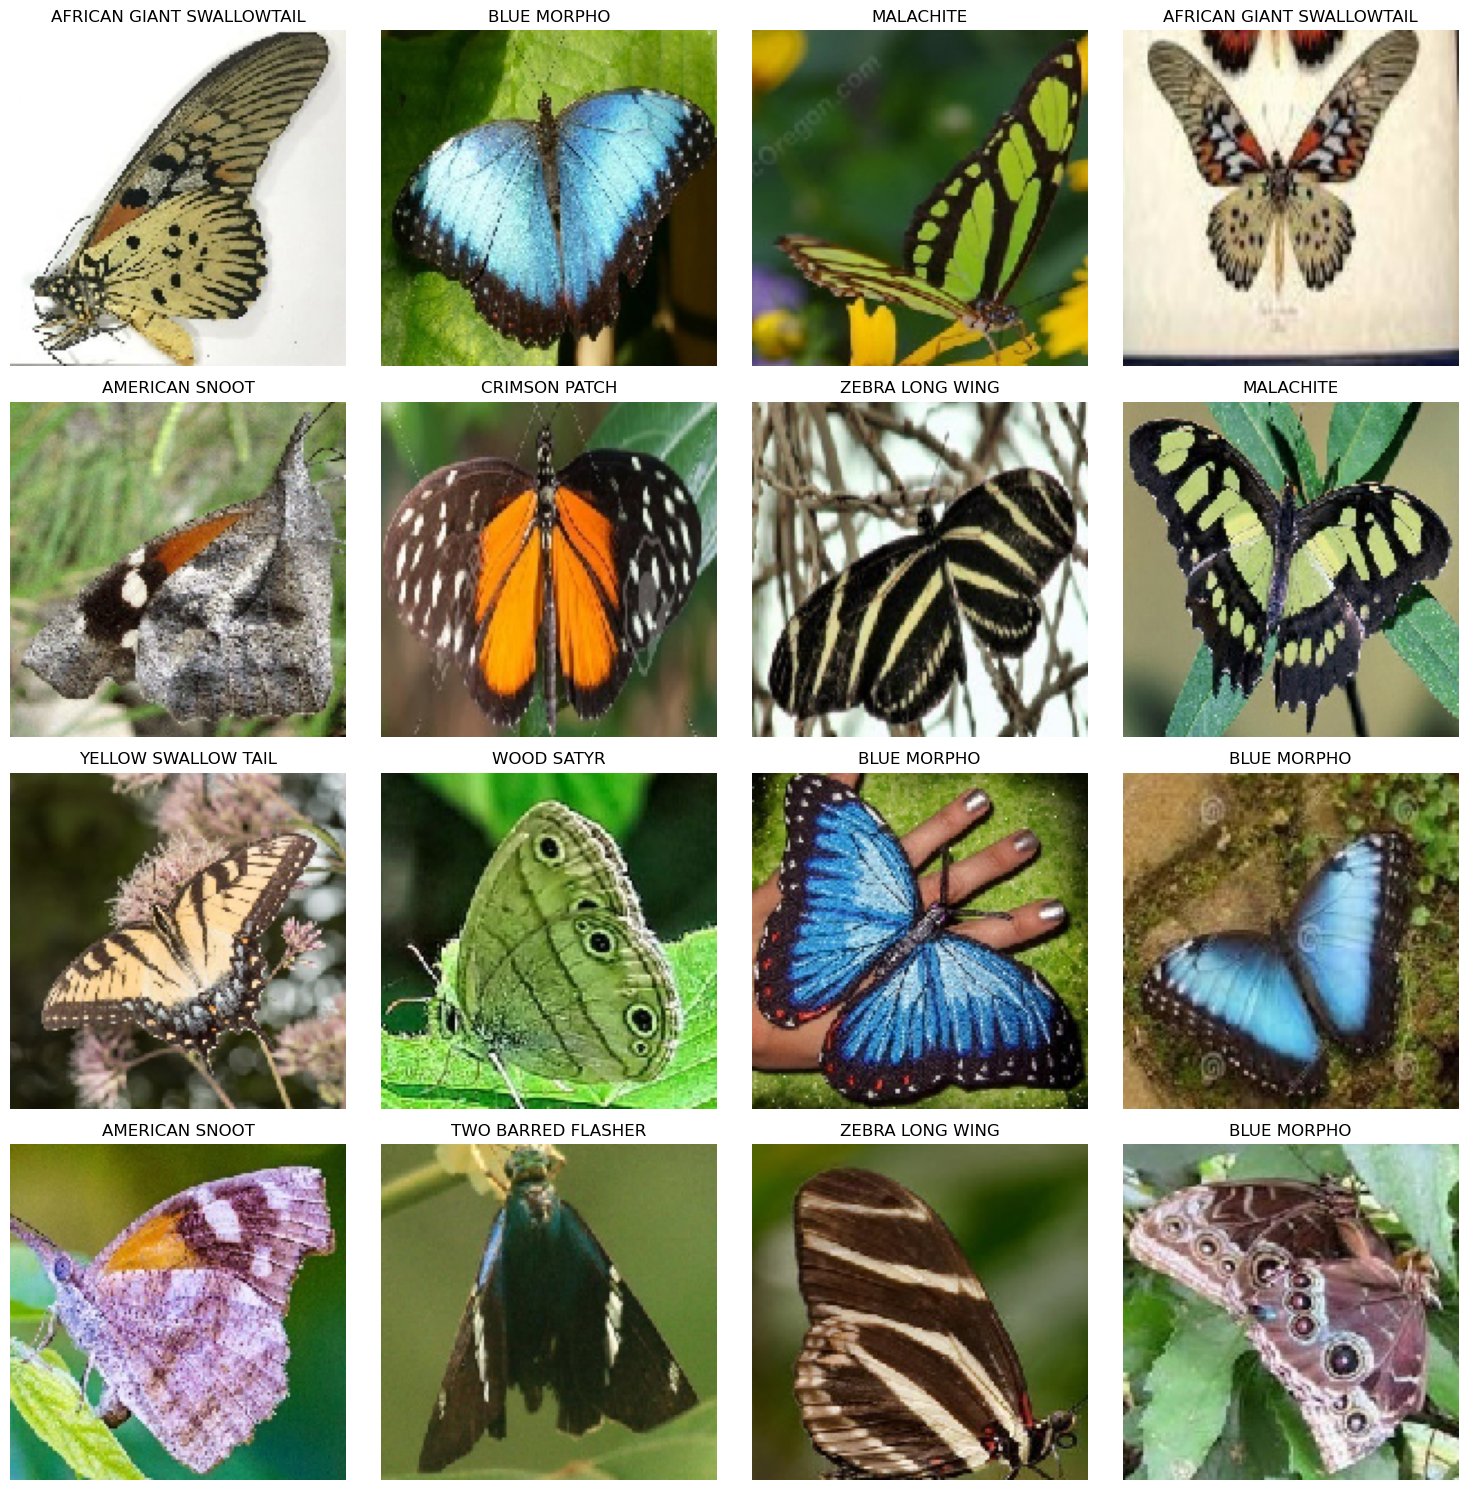

In [207]:
sample_images = df_unknown.sample(16, random_state=42)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = IMAGE_DIR / row['filename']
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 4, i % 4]
    ax.imshow(img_array)
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()


## Split to train and test sets

In [208]:
train, test = train_test_split(df_balanced, test_size=0.2, random_state=42)
train.size, test.size

(7904, 1976)

### Add all unknown class elements to test set

In [217]:
df_unknown = df_unknown.assign(label='UNKNOWN')
test_with_unknown = pd.concat([test, df_unknown], ignore_index=True)
test_with_unknown.size

3456

## Preprocess images

In [218]:
import tensorflow as tf
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [219]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

test_images_with_unknown = test_generator.flow_from_dataframe(
    dataframe=test_with_unknown,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

test_unknown = test_generator.flow_from_dataframe(
    dataframe=df_unknown,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 3162 validated image filenames belonging to 65 classes.
Found 790 validated image filenames belonging to 65 classes.
Found 988 validated image filenames belonging to 65 classes.
Found 1728 validated image filenames belonging to 66 classes.
Found 740 validated image filenames belonging to 1 classes.


## Pre-trained EfficientNetB0

In [220]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [221]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Logits
logits = tf.keras.layers.Dense(keep_class_number)(x)

# Probabilities
outputs = tf.keras.layers.Softmax()(logits)
model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

print(model.summary())

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
___________________________________________________________________________________________

## Compile model

In [222]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit model

In [223]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
198/198 [==============================] - 84s 404ms/step - loss: 2.8643 - accuracy: 0.2786 - val_loss: 1.2082 - val_accuracy: 0.6937
Epoch 2/25
198/198 [==============================] - 85s 427ms/step - loss: 1.2179 - accuracy: 0.6388 - val_loss: 0.6881 - val_accuracy: 0.8000
Epoch 3/25
198/198 [==============================] - 85s 431ms/step - loss: 0.8191 - accuracy: 0.7457 - val_loss: 0.6041 - val_accuracy: 0.8127
Epoch 4/25
198/198 [==============================] - 85s 429ms/step - loss: 0.6277 - accuracy: 0.7957 - val_loss: 0.5157 - val_accuracy: 0.8456
Epoch 5/25
198/198 [==============================] - 85s 429ms/step - loss: 0.5231 - accuracy: 0.8283 - val_loss: 0.4999 - val_accuracy: 0.8456
Epoch 6/25
198/198 [==============================] - 83s 418ms/step - loss: 0.4560 - accuracy: 0.8580 - val_loss: 0.4864 - val_accuracy: 0.8456
Epoch 7/25
198/198 [==============================] - 82s 414ms/step - loss: 0.3835 - accuracy: 0.8757 - val_loss: 0.4248 - val_ac

## Evaluate model

### Test on existing classes

In [224]:
loss, accuracy = model.evaluate(test_images, verbose=1)
print(f"Test loss: {loss:.2f}")
print("Test accuracy: {:.2f}%".format(accuracy * 100))

62/62 [==============================] - 20s 318ms/step - loss: 0.4262 - accuracy: 0.8866
Test loss: 0.43
Test accuracy: 88.66%


### Test on existing and unknown classes

In [225]:
# Predict only logits
logit_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
logits = logit_model.predict(test_images_with_unknown, verbose=1)

108/108 [==============================] - 37s 328ms/step


In [348]:
def predict_with_unknown(logits, unknown_index, max_threshold, ent_threshold):
    max_logits = np.max(logits, axis=1)
    logit_variances = np.var(logits, axis=1)
    
    # Softmax for normal predictions
    probabilities = tf.nn.softmax(logits, axis=1).numpy()
    predictions = np.argmax(probabilities, axis=1)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-7), axis=1)
    
    # Mark predictions as unknown if max logit is below the threshold
    predictions[(max_logits < max_threshold) & (entropy > ent_threshold)] = unknown_index
    
    return predictions, probabilities


In [349]:
MAX_THRESHOLD = 5
ENT_THRESHOLD = 0.4

# Mapping prediction indices to labels
class_labels = {i: label for i, label in enumerate(test_images_with_unknown.class_indices.keys())}
labels = np.array(list(class_labels.values()))
unknown_index = np.where(labels == 'UNKNOWN')[0].squeeze()

# Get true labels
true_labels_one_hot = np.concatenate([test_images_with_unknown[i][1] for i in range(len(test_images_with_unknown))])
true = np.argmax(true_labels_one_hot, axis=1)

# Get predictions
predictions, probabilities = predict_with_unknown(logits, unknown_index, MAX_THRESHOLD, ENT_THRESHOLD)

# Convert predictions to labels
predicted_labels = [class_labels[i] for i in predictions]
true_labels = [class_labels[i] for i in true]

### Accuracy values for known and unknown test images

In [350]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

UNKNOWN_LABEL = "UNKNOWN"

true_is_unknown = (true_labels == UNKNOWN_LABEL)
predicted_is_unknown = (predicted_labels == UNKNOWN_LABEL)

unknown_matches = np.sum(true_is_unknown & predicted_is_unknown)
unknown_total = np.sum(true_is_unknown)

known_matches = np.sum(~true_is_unknown & (true_labels == predicted_labels))
known_total = np.sum(~true_is_unknown)

unknown_accuracy = (unknown_matches / unknown_total) * 100 if unknown_total > 0 else 0
known_accuracy = (known_matches / known_total) * 100 if known_total > 0 else 0

print(f"Unknown Class Accuracy: {unknown_accuracy:.2f}% ({unknown_matches}/{unknown_total})")
print(f"Known Classes Accuracy: {known_accuracy:.2f}% ({known_matches}/{known_total})")

Unknown Class Accuracy: 81.76% (605/740)
Known Classes Accuracy: 76.82% (759/988)


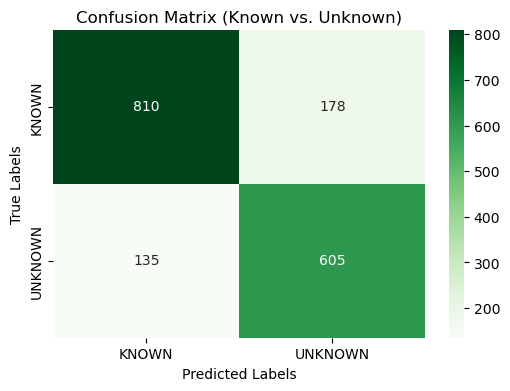

In [351]:
true_binary = []
predicted_binary = []

# Convert true and predicted labels to binary (KNOWN = 0, UNKNOWN = 1)
true_binary = np.where(true_labels == "UNKNOWN", 1, 0)
predicted_binary = np.where(predicted_labels == "UNKNOWN", 1, 0)

# Generate confusion matrix
cm = confusion_matrix(true_binary, predicted_binary, labels=[0, 1])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["KNOWN", "UNKNOWN"], yticklabels=["KNOWN", "UNKNOWN"])
plt.title('Confusion Matrix (Known vs. Unknown)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Which classes are mistaken as unknown?

In [352]:
from collections import Counter
mistaken_as_unknown = true_labels[~true_is_unknown & predicted_is_unknown]

# Count occurrences of each mistaken label
mistake_counts = Counter(mistaken_as_unknown)
mistakes = sorted(mistake_counts.items(), key=lambda x: x[1], reverse=True)

print("Labels mistaken as UNKNOWN:")
for label, count in mistakes:
    print(f"{label}: {count}")

Labels mistaken as UNKNOWN:
VICEROY: 15
MANGROVE SKIPPER: 11
COPPER TAIL: 9
GREAT JAY: 9
INDRA SWALLOW: 9
MESTRA: 8
CRECENT: 7
DANAID EGGFLY: 7
PURPLISH COPPER: 6
ELBOWED PIERROT: 6
CLODIUS PARNASSIAN: 5
ADONIS: 5
POPINJAY: 4
SOOTYWING: 4
RED ADMIRAL: 4
SOUTHERN DOGFACE: 4
BECKERS WHITE: 3
ULYSES: 3
CLEOPATRA: 3
GREAT EGGFLY: 3
TROPICAL LEAFWING: 3
CHECQUERED SKIPPER: 3
QUESTION MARK: 3
EASTERN PINE ELFIN: 3
BLACK HAIRSTREAK: 2
CLOUDED SULPHUR: 2
BLUE SPOTTED CROW: 2
MILBERTS TORTOISESHELL: 2
COMMON WOOD-NYMPH: 2
RED CRACKER: 2
BANDED PEACOCK: 2
PAINTED LADY: 2
CAIRNS BIRDWING: 2
ORCHARD SWALLOW: 2
PURPLE HAIRSTREAK: 2
ORANGE TIP: 2
BROWN SIPROETA: 1
GREEN CELLED CATTLEHEART: 1
PINE WHITE: 1
MOURNING CLOAK: 1
IPHICLUS SISTER: 1
EASTERN DAPPLE WHITE: 1
STRAITED QUEEN: 1
BANDED ORANGE HELICONIAN: 1
METALMARK: 1
JULIA: 1
SILVER SPOT SKIPPER: 1
GREY HAIRSTREAK: 1
LARGE MARBLE: 1
ATALA: 1
SCARCE SWALLOW: 1
EASTERN COMA: 1
RED SPOTTED PURPLE: 1


## Test on entirely different images

In [358]:
from PIL import Image
OUTLIER_DIR = Path('./outliers')

In [359]:
def load_and_preprocess_images(image_dir):
    images = []
    image_filenames = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path)
            img = img.resize((224, 224))
            img = np.array(img)

            # Ensure 3 channels
            if img.shape[-1] != 3:
                img = np.stack([img] * 3, axis=-1)
            
            images.append(img)
            image_filenames.append(filename)
    
    images = np.array(images)

    images = tf.keras.applications.efficientnet.preprocess_input(images)
    return images, image_filenames

In [372]:
outlier_test_images, filenames = load_and_preprocess_images(OUTLIER_DIR)

In [373]:
outlier_logits = logit_model.predict(outlier_test_images, verbose=1)

1/1 [==============================] - 0s 211ms/step


In [374]:
predictions, probabilities = predict_with_unknown(outlier_logits, unknown_index, MAX_THRESHOLD, ENT_THRESHOLD)

In [375]:
predictions == unknown_index

array([ True,  True,  True,  True,  True])

In [353]:
model.save_weights("butterflies_efficientnet_with_unknown_256_256.keras")